In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.stats import t
from scipy import stats

In [22]:
#ich habe als unabhängige Variable folgende
# - Temperatur
# - Preis
# - Uhrzeit - mit Sin und Cos ausgedrückt um das zyklische Verhalten zu bekommen. 
#   Ich habe weiters auch noch sin(2Pi*x/12) und mit cos hinzugefügt um Vor- und Nachmittagsspitzen darzustelle. Ich bin mir ned sicher ob dies nötig/richtig ist
# - Lag: ich habe eine Abhängigkeit von der vorherigen Last hinzugefügt, ich weiß wieder nicht ob das gewollt ist, es verbessert den R² aber deutlich. 

df_price = pd.read_csv("preise2023.csv")
df_load = pd.read_csv("load2023.csv")
hours = pd.Series(range(8760))    #csv eingelesen und hours erstellt
df_temp = pd.read_csv("MessstationenStundendaten.csv")
timeseries = list(range(24))*365
clock = pd.Series(timeseries)
df_sinclock = np.sin(2 * np.pi * clock / 24)
df_cosclock = np.cos(2 * np.pi * clock / 24)
df_sinclock_half = np.sin(2 * np.pi * clock / 12)
df_cosclock_half = np.cos(2 * np.pi * clock / 12)

df_temp.rename(columns={'tl': 'Temp'}, inplace=True)
df_price.rename(columns={'AT': 'Price'}, inplace=True)
df_load.rename(columns={'load': 'Load'}, inplace=True)  #csv Spaltennamen renamed
df_combined = pd.concat([hours, clock, df_price['Price'], df_load['Load'], df_temp['Temp']], axis=1) #daten in ein dataframegepackt 
df_combined.rename(columns={df_combined.columns[0]: 'hours'}, inplace=True) #hours spalte in hours umbenannt
df_combined.rename(columns={df_combined.columns[1]: 'clock'}, inplace=True) #hours spalte in clock umbenannt
df_combined['Load_lagged'] = df_combined['Load'].shift(1) #Setzt meinen Wert in Zusammenhang mit dem t-1 Wert
#df_combined['Sin_clock'] = df_sinclock                  #Uhrzeit durch Sin ausdrücken ist nicht signifikant
df_combined['Cos_clock'] = df_cosclock                  #Uhrzeit durch Cos ausdrücken
df_combined['Sin_clock_half'] = df_sinclock_half               #Uhrzeit durch Sin ausdrücken
df_combined['Cos_clock_half'] = df_cosclock_half                  #Uhrzeit durch Cos ausdrücken
df_combined = df_combined[df_combined['Price'] > 0]     #Preise unter 0 weggecuttet -> nicht wegcutten, sondern 0 setzen
df_combined = df_combined.fillna(df_combined.mean())    #Tauscht Nan-Werte mit Spaltenmittelwert aus (Temp. hatte Nan-Werte) -> könnte man noch verbessern wenn man z.B. mittelwert aus 7 & 9 Uhr für fehlenden wert bei 8 Uhr verwendet.


# Modell 1

In [23]:
X = df_combined[['Temp']]  # Unabhängige Variablen definieren
X = sm.add_constant(X)  # Konstanten-Term hinzufügen (Intercept)

y = df_combined['Load']  # Zielvariable

model = sm.OLS(y, X).fit()  # OLS-Regression (Ordinary Least Squares)

# Ergebnisse ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     1614.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):          1.48e-323
Time:                        11:50:55   Log-Likelihood:                -73360.
No. Observations:                8623   AIC:                         1.467e+05
Df Residuals:                    8621   BIC:                         1.467e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7305.3252     20.403    358.056      0.0

#### 

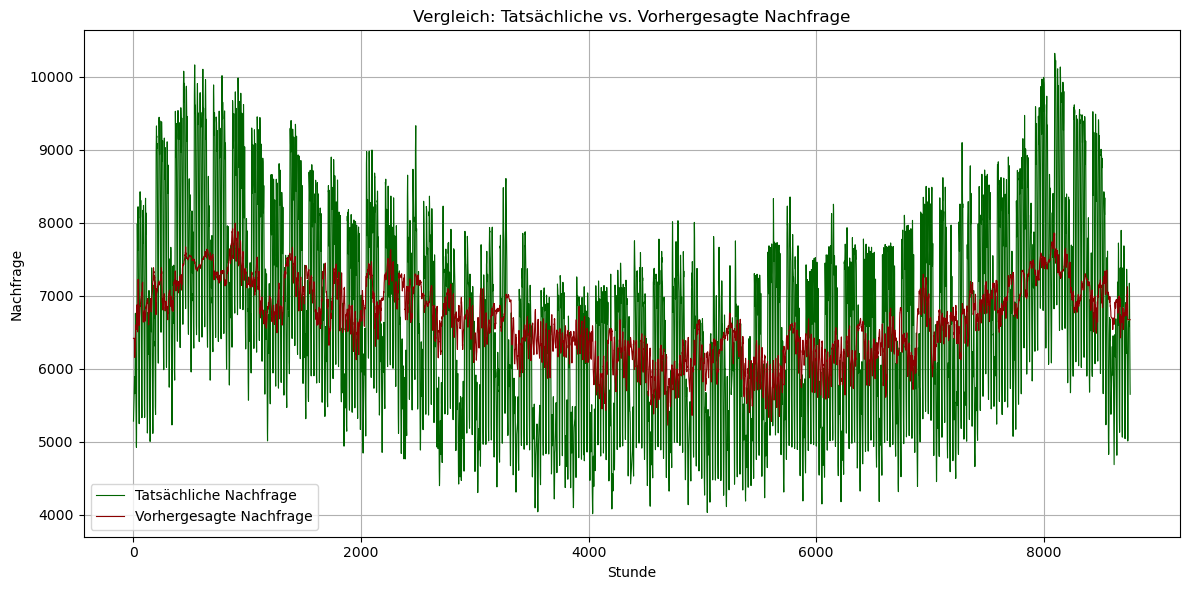

In [24]:
beta0 = 7305.3252
beta1 = -63.5852
df_combined['y_t'] = df_combined['Temp']*beta1+beta0

plt.figure(figsize=(12, 6))
plt.plot(df_combined['hours'], df_combined['Load'], label='Tatsächliche Nachfrage', color='darkgreen', linewidth='0.8')
plt.plot(df_combined['hours'], df_combined['y_t'], label='Vorhergesagte Nachfrage', color='darkred',linewidth='0.8')

plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Nachfrage')
plt.xlabel('Stunde')
plt.ylabel('Nachfrage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

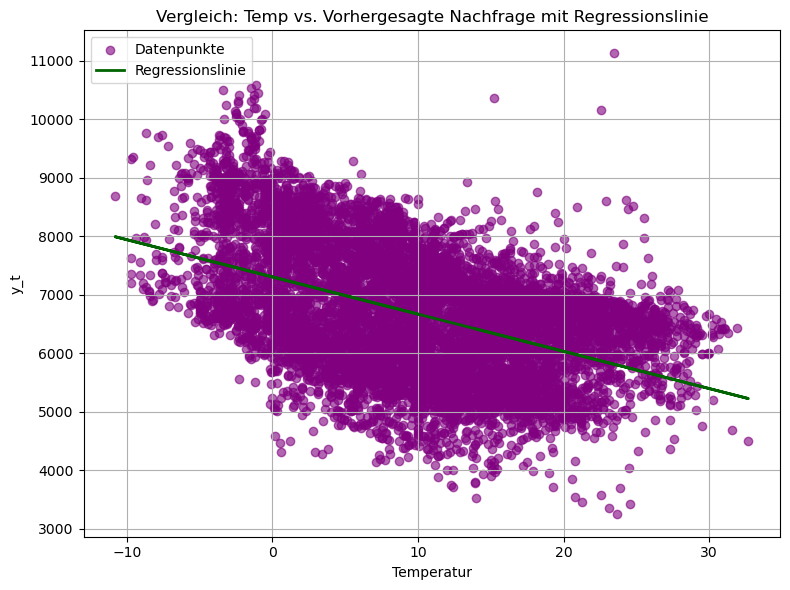

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(df_combined['Temp'], df_combined['y_t'], color='purple', alpha=0.6, label='Datenpunkte')

# Lineare Regression durchführen
slope, intercept, r_value, p_value, std_err = stats.linregress(df_combined['Temp'], df_combined['y_t'])

# Regressionslinie berechnen
regression_line = slope * df_combined['Temp'] + intercept

# Regressionslinie hinzufügen
plt.plot(df_combined['Temp'], regression_line, color='darkgreen', label=f'Regressionslinie',linewidth='2')

# Titel und Achsenbeschriftung hinzufügen
plt.title('Vergleich: Temp vs. Vorhergesagte Nachfrage mit Regressionslinie')
plt.xlabel('Temperatur')
plt.ylabel('y_t')

# Gitter und Layout optimieren
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plot anzeigen
plt.show()

In [26]:
# Berechnung von t_krit
alpha = 0.05  # Signifikanzniveau
df = 8621  # Freiheitsgrade

t_critical = t.ppf(1 - alpha/2, df)  # Zweiseitiger Test
print(round(t_critical,2))

1.96


#### Interpretation: R-squared ist sehr schlecht, was bedeutet, dass die Nachfrage zwar von der Temperatur abhängt, diese aber die Nachfrage nicht vollständig abbildet. Weiters erkennbar ist, dass der Parameter Temperatur eindeutig statistisch signifikant ist, da der t-wert betragsmäßig größer dem Grenzwert und der p-wert kleiner dem Grenzwert ist. 

# Modell 2

In [27]:
X = df_combined[['Price','Temp','Cos_clock','hours']]  # Unabhängige Variablen definieren
X = sm.add_constant(X)  # Konstanten-Term hinzufügen (Intercept)

y = df_combined['Load']  # Zielvariable

model = sm.OLS(y, X).fit()  # OLS-Regression (Ordinary Least Squares)

# Ergebnisse ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     5524.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:50:55   Log-Likelihood:                -68621.
No. Observations:                8623   AIC:                         1.373e+05
Df Residuals:                    8618   BIC:                         1.373e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5301.1056     31.587    167.824      0.0

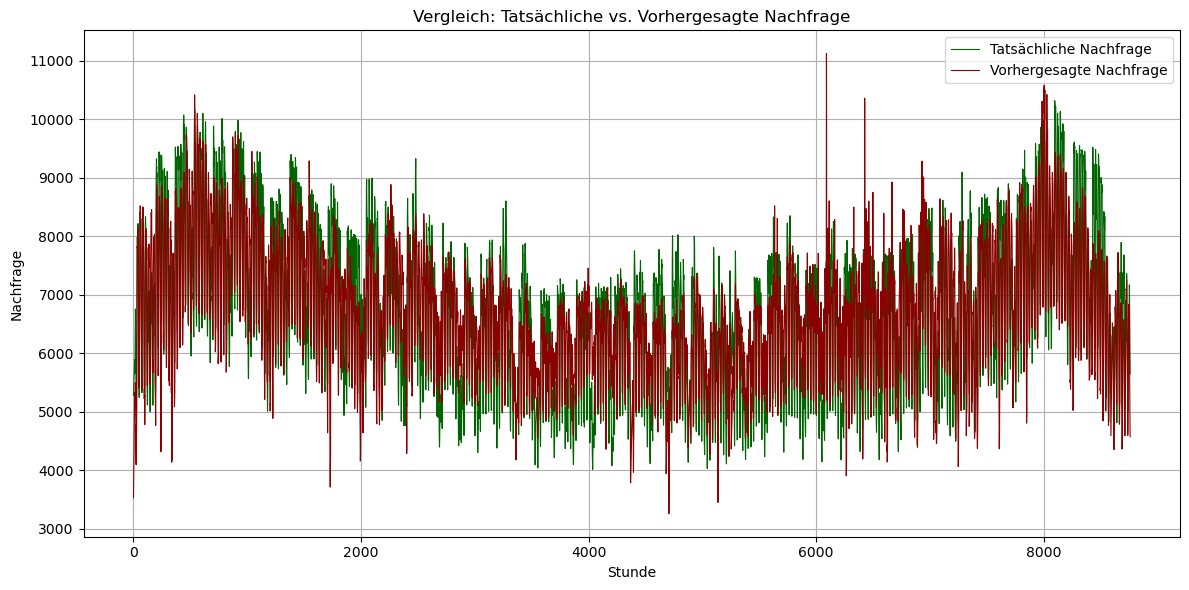

In [28]:
beta0 = 5301.1056
beta1 = 153.9536     
beta2 = -62.2907
beta3 = -1084.2241
beta4 = 0.0911
df_combined['y_t'] = beta0 + beta1*df_combined['Price']+beta2*df_combined['Temp']+beta3*df_combined['Cos_clock']+beta4*df_combined['hours']

plt.figure(figsize=(12, 6))
plt.plot(df_combined['hours'], df_combined['Load'], label='Tatsächliche Nachfrage', color='darkgreen', linewidth='0.8')
plt.plot(df_combined['hours'], df_combined['y_t'], label='Vorhergesagte Nachfrage', color='darkred',linewidth='0.8')

plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Nachfrage')
plt.xlabel('Stunde')
plt.ylabel('Nachfrage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Modell 3 - warum cos-clock?

In [34]:
X = df_combined[['Price','Temp','hours']]  # Unabhängige Variablen definieren
X = sm.add_constant(X)  # Konstanten-Term hinzufügen (Intercept)

y = df_combined['Load']  # Zielvariable

model = sm.OLS(y, X).fit()  # OLS-Regression (Ordinary Least Squares)

# Ergebnisse ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     1802.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:56:25   Log-Likelihood:                -72001.
No. Observations:                8623   AIC:                         1.440e+05
Df Residuals:                    8619   BIC:                         1.440e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5050.6322     46.599    108.384      0.0

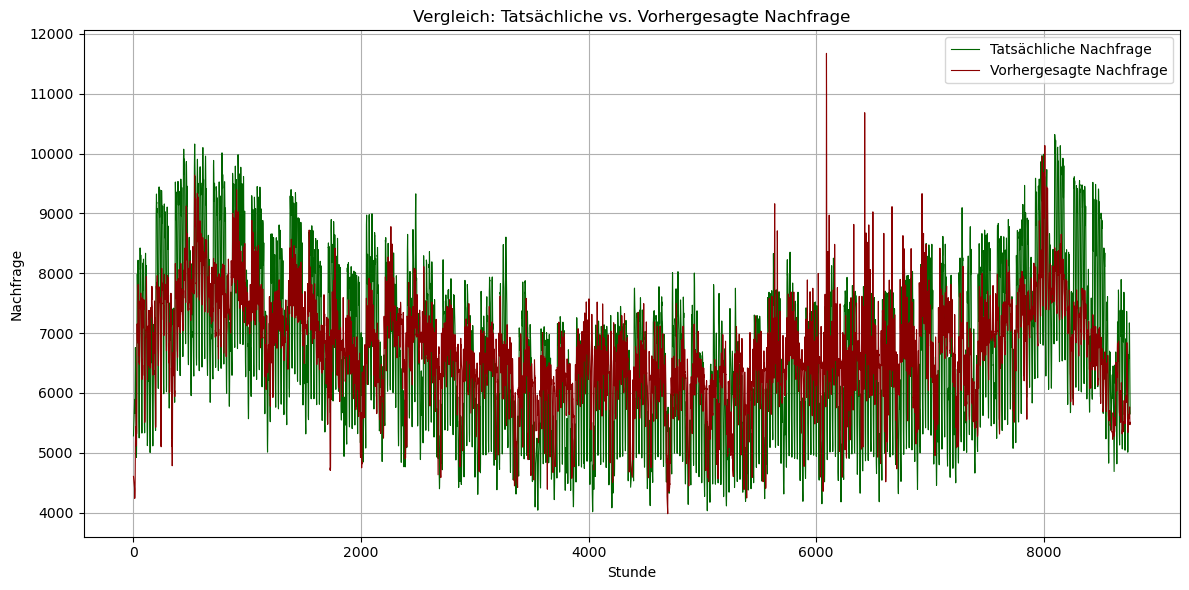

In [35]:
beta0 = 5050.6322
beta1 = 164.3577     
beta2 = -46.0643
beta3 = 0.0849
df_combined['y_t'] = beta0 + beta1*df_combined['Price']+beta2*df_combined['Temp']+beta3*df_combined['hours']

plt.figure(figsize=(12, 6))
plt.plot(df_combined['hours'], df_combined['Load'], label='Tatsächliche Nachfrage', color='darkgreen', linewidth='0.8')
plt.plot(df_combined['hours'], df_combined['y_t'], label='Vorhergesagte Nachfrage', color='darkred',linewidth='0.8')

plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Nachfrage')
plt.xlabel('Stunde')
plt.ylabel('Nachfrage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()